In [ ]:
!nvidia-smi

In [1]:


from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
device = torch.device("cuda:2")

In [ ]:
#!git clone https://github.com/pacifinapacific/StyleGAN_LatentEditor


In [3]:
import json
from urllib.request import urlretrieve

# 이미지넷(ImageNet)에 정의된 1,000개의 레이블(클래스) 정보 가져오기
imagenet_json, _ = urlretrieve('http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)
print(imagenet_labels[18])

magpie


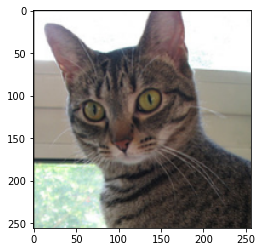

In [4]:
import matplotlib.pyplot as plt
import PIL

imsize = 256

preprocess = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize), 
    transforms.ToTensor(), 
])

def image_loader(path):
    image = PIL.Image.open(path)
    image = preprocess(image).unsqueeze(0) #베치 차원
    return image.to(device, torch.float) # raw한 이미지 GPU로 올릴때 float로 올려주기 

image= image_loader('./cat11.png')

def imshow(tensor):
    # matplotlib는 CPU 기반이므로 CPU로 옮기기 기억하기
    image = tensor.cpu().clone()
    image = image.squeeze(0) #배치차원 제거
    # PIL 객체로 변경 
    image = transforms.ToPILImage()(image) #토치 transform기능중 PIL로 변경
    # 이미지를 화면에 출력(matplotlib는 [0, 1] 사이의 값이라고 해도 정상적으로 처리)
    plt.imshow(image)
plt.figure()
imshow(image)

In [5]:
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

classifier = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  #Inception v3 의 정규화
    torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
).to(device).eval() 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [6]:
!pwd
%cd ./StyleGAN_LatentEditor/
!pwd

/workspace/StyleGAN_adver실험
/workspace/StyleGAN_adver실험/StyleGAN_LatentEditor
/workspace/StyleGAN_adver실험/StyleGAN_LatentEditor


In [15]:
#from stylegan_layers import G_mapping, G_synthesis
from collections import OrderedDict

g_all = nn.Sequential(OrderedDict([
    ('g_mapping', G_mapping()),
    ('g_synthesis', G_synthesis(resolution=256))  
]))

g_all.load_state_dict(torch.load("karras2019stylegan-cats-256x256.pt", map_location=device))
g_all.eval()
g_all.to(device)

g_mapping, generator = g_all[0], g_all[1]
generator.use_noise = False


In [11]:
#generator

In [16]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [17]:
generator.blocks["4x4"].epi1.top_epi.noise = Identity()
generator.blocks["4x4"].epi2.top_epi.noise = Identity()
generator.blocks["8x8"].epi1.top_epi.noise = Identity()
generator.blocks["8x8"].epi2.top_epi.noise = Identity()
generator.blocks["16x16"].epi1.top_epi.noise = Identity()
generator.blocks["16x16"].epi2.top_epi.noise = Identity()
generator.blocks["32x32"].epi1.top_epi.noise = Identity()
generator.blocks["32x32"].epi2.top_epi.noise = Identity()
generator.blocks["64x64"].epi1.top_epi.noise = Identity()
generator.blocks["64x64"].epi2.top_epi.noise = Identity()
generator.blocks["128x128"].epi1.top_epi.noise = Identity()
generator.blocks["128x128"].epi2.top_epi.noise = Identity()
generator.blocks["256x256"].epi1.top_epi.noise = Identity()
generator.blocks["256x256"].epi2.top_epi.noise = Identity()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])


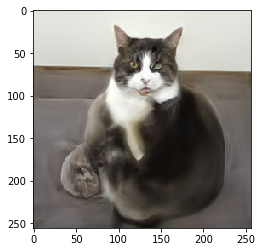

In [18]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device)
synth_img = generator(latent)

plt.imshow( ( (synth_img + 1.0) / 2.0)[0].detach().cpu().squeeze(0).permute(1, 2, 0))
plt.show()

In [19]:
import torch.optim as optim

def unrestricted_attack(generator, classifier, ori_label, trg_label, eps, alpha, iters):
    trg_label = trg_label.to(device)

    latent = torch.zeros((1, 18, 512), requires_grad=True, device=device)
    perturbation = torch.empty_like(latent).uniform_(-eps, eps)
    perturbation.to(device)

    attack_loss = nn.CrossEntropyLoss() # 타겟티드 어택으로 목표 클래스로 분류되도록
    mse = torch.nn.MSELoss(reduction='sum') # 초기 이미지와 유사하도록 , 출력값 다 더함

    # 시작 당시의 이미지 정보
    start_generated = generator(latent)

    print("[ 현재 이미지 ]")
    plt.imshow(((start_generated + 1.0) / 2.0)[0].detach().cpu().squeeze(0).permute(1, 2, 0))
    plt.show()
    
    attack_success_list=[]
    
    for i in range(iters):
        perturbation.requires_grad = True
        now = latent + perturbation

        generator.zero_grad()
        classifier.zero_grad()

        generated = generator(now)
        outputs = classifier((generated + 1.0) / 2.0)

        if i % 20 == 0:
            print(f"[ i = {i} ]")
            print("[ 현재 이미지 ]")
            plt.imshow(((generated + 1.0) / 2.0)[0].detach().cpu().squeeze(0).permute(1, 2, 0))
            plt.show()
            percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
            print("< 가장 높은 확률을 가지는 클래스들 >")
            for i in outputs[0].topk(3)[1]:
                print(f"인덱스: {i.item()} / 클래스명: {imagenet_labels[i]} / 확률: {round(percentages[i].item(), 4)}%")
        
        if outputs[0].topk(1)[1] == 18:
            attack_success_list.append(f'{i} 번째 :,{round(percentages[i].item(), 4)}% 로 성공' )
        
        cost = attack_loss(outputs, trg_label).to(device) * 1e3 #1000을곱함
        cost += mse(generated, start_generated).to(device) #현재 입력과 만들어진 입력간의 mse 
        cost.backward(retain_graph=True) # 시작 이미지에 대한 기울기 정보는 유지(retain)될 수 있도록

        # 계산된 기울기(gradient)를 이용하여 손실 함수가 감소하는 방향으로 업데이트
        diff = - alpha * perturbation.grad.sign()
        perturbation = torch.clamp(perturbation + diff, min=-eps, max=eps).detach_()
        
        #print(attack_success_list)
        
    return latent, perturbation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ 현재 이미지 ]


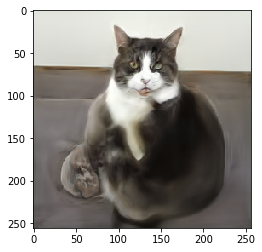

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 0 ]
[ 현재 이미지 ]


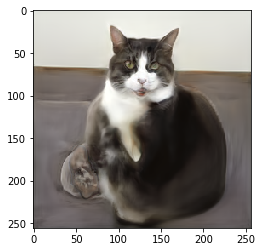

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 74.7702%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 17.9689%
인덱스: 282 / 클래스명: tiger cat / 확률: 6.9198%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 20 ]
[ 현재 이미지 ]


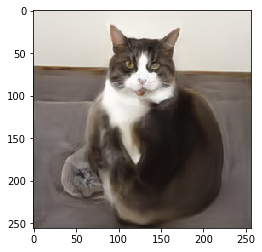

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 38.6093%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 32.6308%
인덱스: 284 / 클래스명: Siamese cat, Siamese / 확률: 7.9881%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 40 ]
[ 현재 이미지 ]


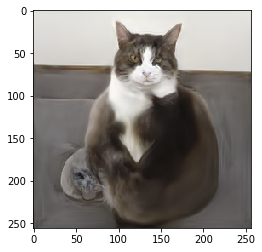

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 52.7968%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 14.1719%
인덱스: 284 / 클래스명: Siamese cat, Siamese / 확률: 4.4394%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input 

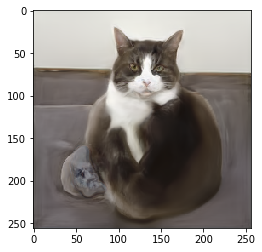

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 16.8925%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 13.3618%
인덱스: 284 / 클래스명: Siamese cat, Siamese / 확률: 11.3506%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 80 ]
[ 현재 이미지 ]


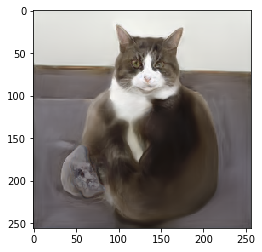

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 30.2918%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 14.1665%
인덱스: 282 / 클래스명: tiger cat / 확률: 9.2116%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 100 ]
[ 현재 이미지 ]


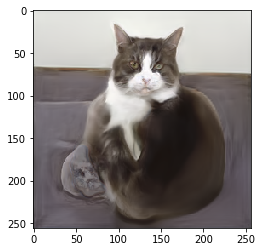

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 14.0625%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 10.8934%
인덱스: 282 / 클래스명: tiger cat / 확률: 8.756%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 120 ]
[ 현재 이미지 ]


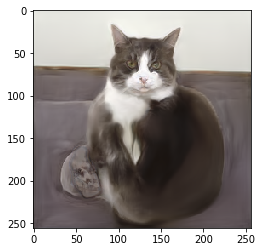

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 4.7668%
인덱스: 282 / 클래스명: tiger cat / 확률: 4.3288%
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 4.1558%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input laye

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 140 ]
[ 현재 이미지 ]


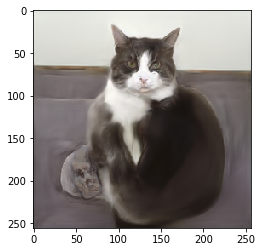

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 7.6543%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 5.5449%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 4.0356%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 160 ]
[ 현재 이미지 ]


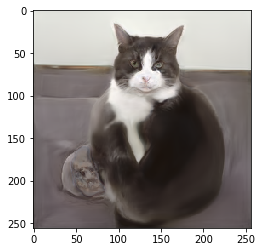

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 14.0419%
인덱스: 851 / 클래스명: television, television system / 확률: 11.1401%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 7.937%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
cons

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 180 ]
[ 현재 이미지 ]


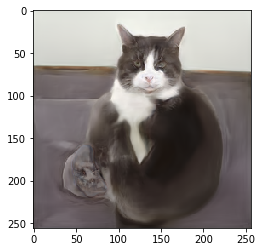

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 12.3853%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 10.8846%
인덱스: 722 / 클래스명: ping-pong ball / 확률: 7.0837%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const inp

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


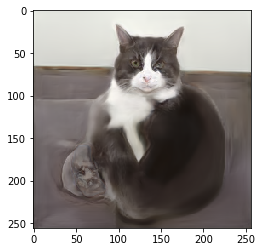

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 19.8735%
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 16.7535%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 12.313%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 220 ]
[ 현재 이미지 ]


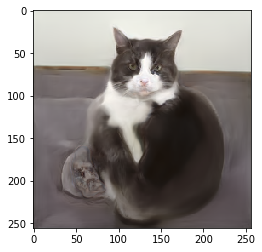

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 22.4002%
인덱스: 18 / 클래스명: magpie / 확률: 21.3016%
인덱스: 722 / 클래스명: ping-pong ball / 확률: 7.9022%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 240 ]
[ 현재 이미지 ]


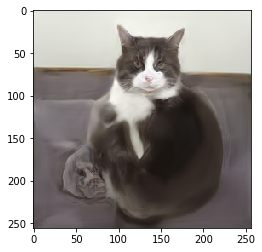

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 16.9139%
인덱스: 722 / 클래스명: ping-pong ball / 확률: 7.708%
인덱스: 370 / 클래스명: guenon, guenon monkey / 확률: 6.7155%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input lay

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 260 ]
[ 현재 이미지 ]


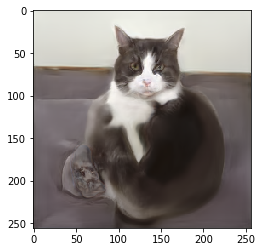

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 12.5501%
인덱스: 18 / 클래스명: magpie / 확률: 11.6202%
인덱스: 508 / 클래스명: computer keyboard, keypad / 확률: 5.4165%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 280 ]
[ 현재 이미지 ]


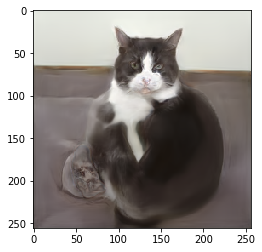

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 63.833%
인덱스: 435 / 클래스명: bathtub, bathing tub, bath, tub / 확률: 4.7235%
인덱스: 508 / 클래스명: computer keyboard, keypad / 확률: 3.5039%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
c

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 300 ]
[ 현재 이미지 ]


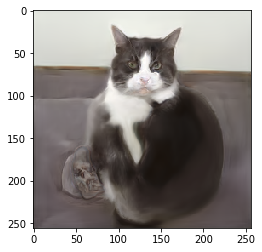

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 56.7228%
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 8.8691%
인덱스: 508 / 클래스명: computer keyboard, keypad / 확률: 2.9241%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const inpu

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 320 ]
[ 현재 이미지 ]


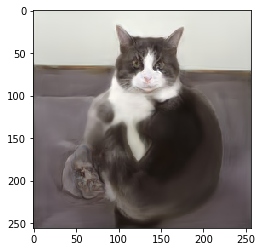

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 55.1673%
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 3.1837%
인덱스: 508 / 클래스명: computer keyboard, keypad / 확률: 2.9641%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const inpu

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 340 ]
[ 현재 이미지 ]


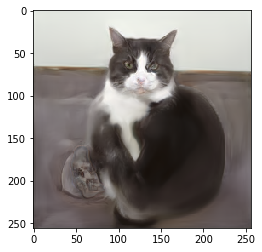

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 622 / 클래스명: lens cap, lens cover / 확률: 7.7815%
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 7.6332%
인덱스: 891 / 클래스명: waffle iron / 확률: 4.8902%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const inpu

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 360 ]
[ 현재 이미지 ]


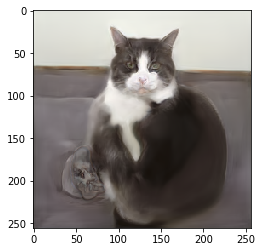

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 12.4463%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 7.4097%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 6.392%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 c

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 380 ]
[ 현재 이미지 ]


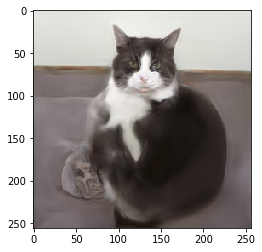

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 82.7921%
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 1.4126%
인덱스: 722 / 클래스명: ping-pong ball / 확률: 1.3684%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 400 ]
[ 현재 이미지 ]


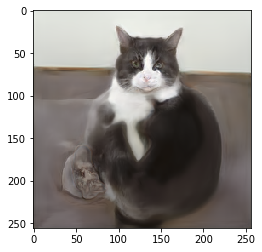

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 89.5264%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 1.3473%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 0.9933%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 420 ]
[ 현재 이미지 ]


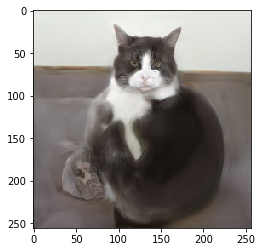

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 88.5805%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 0.9843%
인덱스: 435 / 클래스명: bathtub, bathing tub, bath, tub / 확률: 0.7863%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 440 ]
[ 현재 이미지 ]


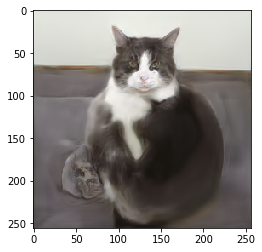

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 83.5866%
인덱스: 851 / 클래스명: television, television system / 확률: 1.7143%
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 1.0376%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 460 ]
[ 현재 이미지 ]


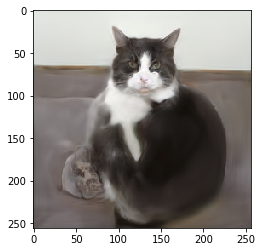

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 81.7468%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 0.8985%
인덱스: 722 / 클래스명: ping-pong ball / 확률: 0.782%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 con

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
[ i = 480 ]
[ 현재 이미지 ]


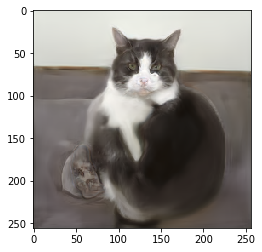

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 76.9522%
인덱스: 722 / 클래스명: ping-pong ball / 확률: 4.5782%
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 2.1453%
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동
epi1 끝 conv2시작
torch.Size([1, 512, 4, 4])
const input layer 발동


In [20]:
# 공격용 파라미터 설정
eps = 8/255
alpha = 0.5/255
iters = 500

# 얼룩 고양이(tabby cat)으로 보이도록 설정
ori_label = "tabby cat" # index: 281

# 까치(magpie)로 분류되도록 공격 수행
trg_label = [18]
trg_label = torch.Tensor(trg_label)
trg_label = trg_label.type(torch.long)

latent, perturbation = unrestricted_attack(generator, classifier, ori_label, trg_label, eps, alpha, iters)

In [ ]:
device

In [ ]:
import torch.optim as optim

def unrestricted_attack2(generator, classifier, ori_label, trg_label, eps, alpha, iters):
    trg_label = trg_label.to(device)

    latent = torch.zeros((1, 18, 512), requires_grad=True, device=device)
    perturbation = torch.empty_like(latent).uniform_(-eps, eps)
    perturbation.to(device)

    attack_loss = nn.CrossEntropyLoss() # 타겟티드 어택으로 목표 클래스로 분류되도록
    mse = torch.nn.MSELoss(reduction='sum') # 초기 이미지와 유사하도록 , 출력값 다 더함

    # 시작 당시의 이미지 정보
    start_generated = generator(latent)

    print("[ 현재 이미지 ]")
    plt.imshow(((start_generated + 1.0) / 2.0)[0].detach().cpu().squeeze(0).permute(1, 2, 0))
    plt.show()

    for i in range(iters):
        perturbation.requires_grad = True
        now = latent + perturbation

        generator.zero_grad()
        classifier.zero_grad()

        generated = generator(now)
        outputs = classifier((generated + 1.0) / 2.0)

        if i % 20 == 0:
            print(f"[ i = {i} ]")
            print("[ 현재 이미지 ]")
            plt.imshow(((generated + 1.0) / 2.0)[0].detach().cpu().squeeze(0).permute(1, 2, 0))
            plt.show()
            percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
            print("< 가장 높은 확률을 가지는 클래스들 >")
            for i in outputs[0].topk(3)[1]:
                print(f"인덱스: {i.item()} / 클래스명: {imagenet_labels[i]} / 확률: {round(percentages[i].item(), 4)}%")

        cost = attack_loss(outputs, trg_label).to(device) * 1e3 #1000을곱함
        cost += mse(generated, start_generated).to(device) #현재 입력과 만들어진 입력간의 mse 
        cost.backward(retain_graph=True) # 시작 이미지에 대한 기울기 정보는 유지(retain)될 수 있도록

        # 계산된 기울기(gradient)를 이용하여 손실 함수가 감소하는 방향으로 업데이트
        diff = - alpha * perturbation.grad.sign()
        perturbation = torch.clamp(perturbation + diff, min=-eps, max=eps).detach_()

    return latent, perturbation

In [ ]:
a=generator.blocks["4x4"].epi1

In [ ]:

# a=list(generator.children())[1]
# b=list(a.children())
# c=list(b[0].children())
# d=list(c[0].children())
# d.append( ('perturlayer', Perturlayer()) )

# d



In [16]:
nf = 512
dlatent_size = 512
use_wscale=True
use_noise = True
use_pixel_norm = False
use_instance_norm=True
use_styles=True
activation_layer= nn.LeakyReLU(negative_slope=0.2)

In [23]:
generator.blocks["4x4"].epi1 = LayerEpilogue2(nf, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
generator

G_synthesis(
  (torgb): MyConv2d()
  (blocks): ModuleDict(
    (4x4): InputBlock(
      (epi1): LayerEpilogue2(
        (top_epi): Sequential(
          (noise): NoiseLayer()
          (activation): LeakyReLU(negative_slope=0.2)
          (instance_norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (style_mod): StyleMod(
          (lin): MyLinear()
        )
        (perturlayer): Perturlayer()
      )
      (conv): MyConv2d()
      (epi2): LayerEpilogue(
        (top_epi): Sequential(
          (noise): Identity()
          (activation): LeakyReLU(negative_slope=0.2)
          (instance_norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (style_mod): StyleMod(
          (lin): MyLinear()
        )
      )
    )
    (8x8): GSynthesisBlock(
      (conv0_up): MyConv2d(
        (upscale): Upscale2d()
        (intermediate): BlurLayer()
      )
      (epi1): LayerEpilogue(

In [22]:
class Perturlayer(nn.Module):
    def __init__(self):
        super(Perturlayer, self).__init__()
        
    def forward(self, x , pertur):
        x = x + pertur
        return x

class LayerEpilogue2(nn.Module):
    """Things to do at the end of each layer."""
    def __init__(self, channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer ):
        super().__init__()
        layers = []
        if use_noise:
            layers.append(('noise', NoiseLayer(channels)))
        layers.append(('activation', activation_layer))
        if use_pixel_norm:
            layers.append(('pixel_norm', PixelNorm()))
        if use_instance_norm:
            layers.append(('instance_norm', nn.InstanceNorm2d(channels)))
        self.top_epi = nn.Sequential(OrderedDict(layers))
        if use_styles:
            self.style_mod = StyleMod(dlatent_size, channels, use_wscale=use_wscale)
        else:
            self.style_mod = None
        self.perturlayer = Perturlayer()
    def forward(self, x, dlatents_in_slice=None, perturbation=None ):
        x = self.top_epi(x)
        if self.style_mod is not None:
            x = self.style_mod(x, dlatents_in_slice)
        else:
            assert dlatents_in_slice is None
            
        x= x + self.perturlayer(perturbation)
        return x

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import OrderedDict
import pickle
import numpy as np


class MyLinear(nn.Module):
    """Linear layer with equalized learning rate and custom learning rate multiplier."""
    def __init__(self, input_size, output_size, gain=2**(0.5), use_wscale=False, lrmul=1, bias=True):
        super().__init__()
        he_std = gain * input_size**(-0.5) # He init
        # Equalized learning rate and custom learning rate multiplier.
        if use_wscale:
            init_std = 1.0 / lrmul
            self.w_mul = he_std * lrmul
        else:
            init_std = he_std / lrmul
            self.w_mul = lrmul
        self.weight = torch.nn.Parameter(torch.randn(output_size, input_size) * init_std)
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(output_size))
            self.b_mul = lrmul
        else:
            self.bias = None

    def forward(self, x):
        bias = self.bias
        if bias is not None:
            bias = bias * self.b_mul
        return F.linear(x, self.weight * self.w_mul, bias)

class MyConv2d(nn.Module):
    """Conv layer with equalized learning rate and custom learning rate multiplier."""
    def __init__(self, input_channels, output_channels, kernel_size, stride=1, gain=2**(0.5), use_wscale=False, lrmul=1, bias=True,
                intermediate=None, upscale=False, downscale=False):
        super().__init__()
        if upscale:
            self.upscale = Upscale2d()
        else:
            self.upscale = None
        if downscale:
            self.downscale = Downscale2d()
        else:
            self.downscale = None
        he_std = gain * (input_channels * kernel_size ** 2) ** (-0.5) # He init
        self.kernel_size = kernel_size
        if use_wscale:
            init_std = 1.0 / lrmul
            self.w_mul = he_std * lrmul
        else:
            init_std = he_std / lrmul
            self.w_mul = lrmul
        self.weight = torch.nn.Parameter(torch.randn(output_channels, input_channels, kernel_size, kernel_size) * init_std)
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(output_channels))
            self.b_mul = lrmul
        else:
            self.bias = None
        self.intermediate = intermediate

    def forward(self, x):
        bias = self.bias
        if bias is not None:
            bias = bias * self.b_mul
        
        have_convolution = False
        if self.upscale is not None and min(x.shape[2:]) * 2 >= 128:
            # this is the fused upscale + conv from StyleGAN, sadly this seems incompatible with the non-fused way
            # this really needs to be cleaned up and go into the conv...
            w = self.weight * self.w_mul
            w = w.permute(1, 0, 2, 3)
            # probably applying a conv on w would be more efficient. also this quadruples the weight (average)?!
            w = F.pad(w, (1,1,1,1))
            w = w[:, :, 1:, 1:]+ w[:, :, :-1, 1:] + w[:, :, 1:, :-1] + w[:, :, :-1, :-1]
            x = F.conv_transpose2d(x, w, stride=2, padding=(w.size(-1)-1)//2)
            have_convolution = True
        elif self.upscale is not None:
            x = self.upscale(x)
        
        downscale = self.downscale
        intermediate = self.intermediate
        if downscale is not None and min(x.shape[2:]) >= 128:
            w = self.weight * self.w_mul
            w = F.pad(w, (1,1,1,1))
            # in contrast to upscale, this is a mean...
            w = (w[:, :, 1:, 1:]+ w[:, :, :-1, 1:] + w[:, :, 1:, :-1] + w[:, :, :-1, :-1])*0.25 # avg_pool?
            x = F.conv2d(x, w, stride=2, padding=(w.size(-1)-1)//2)
            have_convolution = True
            downscale = None
        elif downscale is not None:
            assert intermediate is None
            intermediate = downscale
            
        if not have_convolution and intermediate is None:
            return F.conv2d(x, self.weight * self.w_mul, bias, padding=self.kernel_size//2)
        elif not have_convolution:
            x = F.conv2d(x, self.weight * self.w_mul, None, padding=self.kernel_size//2)

        if intermediate is not None:
            x = intermediate(x)

        if bias is not None:
            x = x + bias.view(1, -1, 1, 1)
        return x

class NoiseLayer(nn.Module):
    """adds noise. noise is per pixel (constant over channels) with per-channel weight"""
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(channels))
        self.noise = None
    
    def forward(self, x, noise=None):

        if noise is None and self.noise is None:
            noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=x.device, dtype=x.dtype)
        elif noise is None:
            # here is a little trick: if you get all the noiselayers and set each
            # modules .noise attribute, you can have pre-defined noise.
            # Very useful for analysis
            noise = self.noise

        x = x + self.weight.view(1, -1, 1, 1) * noise
        return x

class StyleMod(nn.Module):
    def __init__(self, latent_size, channels, use_wscale):
        super(StyleMod, self).__init__()
        self.lin = MyLinear(latent_size,
                            channels * 2,
                            gain=1.0, use_wscale=use_wscale)
        
    def forward(self, x, latent):
        style = self.lin(latent) # style => [batch_size, n_channels*2]
        shape = [-1, 2, x.size(1)] + (x.dim() - 2) * [1]
        style = style.view(shape)  # [batch_size, 2, n_channels, ...]
        x = x * (style[:, 0] + 1.) + style[:, 1]
        return x

class PixelNormLayer(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon
    def forward(self, x):
        return x * torch.rsqrt(torch.mean(x**2, dim=1, keepdim=True) + self.epsilon)


class BlurLayer(nn.Module):
    def __init__(self, kernel=[1, 2, 1], normalize=True, flip=False, stride=1):
        super(BlurLayer, self).__init__()
        kernel = torch.tensor(kernel, dtype=torch.float32)
        kernel = kernel[:, None] * kernel[None, :]
        kernel = kernel[None, None]
        if normalize:
            kernel = kernel / kernel.sum()
        if flip:
            kernel = kernel[:, :, ::-1, ::-1]
        self.register_buffer('kernel', kernel)
        self.stride = stride
    
    def forward(self, x):
        # expand kernel channels
        kernel = self.kernel.expand(x.size(1), -1, -1, -1)
        x = F.conv2d(
            x,
            kernel,
            stride=self.stride,
            padding=int((self.kernel.size(2)-1)/2),
            groups=x.size(1)
        )
        return x

def upscale2d(x, factor=2, gain=1):
    assert x.dim() == 4
    if gain != 1:
        x = x * gain
    if factor != 1:
        shape = x.shape
        x = x.view(shape[0], shape[1], shape[2], 1, shape[3], 1).expand(-1, -1, -1, factor, -1, factor)
        x = x.contiguous().view(shape[0], shape[1], factor * shape[2], factor * shape[3])
    return x

class Upscale2d(nn.Module):
    def __init__(self, factor=2, gain=1):
        super().__init__()
        assert isinstance(factor, int) and factor >= 1
        self.gain = gain
        self.factor = factor
    def forward(self, x):
        return upscale2d(x, factor=self.factor, gain=self.gain)


class G_mapping(nn.Sequential):
    def __init__(self, nonlinearity='lrelu', use_wscale=True):
        act, gain = {'relu': (torch.relu, np.sqrt(2)),
                     'lrelu': (nn.LeakyReLU(negative_slope=0.2), np.sqrt(2))}[nonlinearity]
        layers = [
            ('pixel_norm', PixelNormLayer()),
            ('dense0', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense0_act', act),
            ('dense1', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense1_act', act),
            ('dense2', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense2_act', act),
            ('dense3', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense3_act', act),
            ('dense4', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense4_act', act),
            ('dense5', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense5_act', act),
            ('dense6', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense6_act', act),
            ('dense7', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense7_act', act)
        ]
        super().__init__(OrderedDict(layers))
        
    def forward(self, x):
        x = super().forward(x)
        # Broadcast
        x = x.unsqueeze(1).expand(-1, 18, -1)
        return x

class Truncation(nn.Module):
    def __init__(self, avg_latent, max_layer=8, threshold=0.7):
        super().__init__()
        self.max_layer = max_layer
        self.threshold = threshold
        self.register_buffer('avg_latent', avg_latent)
    def forward(self, x):
        assert x.dim() == 3
        interp = torch.lerp(self.avg_latent, x, self.threshold)
        do_trunc = (torch.arange(x.size(1)) < self.max_layer).view(1, -1, 1)
        return torch.where(do_trunc, interp, x)

class LayerEpilogue(nn.Module):
    """Things to do at the end of each layer."""
    def __init__(self, channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        layers = []
        if use_noise:
            layers.append(('noise', NoiseLayer(channels)))
        layers.append(('activation', activation_layer))
        if use_pixel_norm:
            layers.append(('pixel_norm', PixelNorm()))
        if use_instance_norm:
            layers.append(('instance_norm', nn.InstanceNorm2d(channels)))
        self.top_epi = nn.Sequential(OrderedDict(layers))

        if use_styles:
            self.style_mod = StyleMod(dlatent_size, channels, use_wscale=use_wscale)
        else:
            self.style_mod = None
    def forward(self, x, dlatents_in_slice=None):
        x = self.top_epi(x)
        
        if self.style_mod is not None:
            x = self.style_mod(x, dlatents_in_slice)
        else:
            assert dlatents_in_slice is None
        return x


class InputBlock(nn.Module):
    def __init__(self, nf, dlatent_size, const_input_layer, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        self.const_input_layer = const_input_layer
        self.nf = nf
        if self.const_input_layer:
            # called 'const' in tf
            self.const = nn.Parameter(torch.ones(1, nf, 4, 4))
            self.bias = nn.Parameter(torch.ones(nf))
        else:
            self.dense = MyLinear(dlatent_size, nf*16, gain=gain/4, use_wscale=use_wscale) # tweak gain to match the official implementation of Progressing GAN

        self.epi1 = LayerEpilogue(nf, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        self.conv = MyConv2d(nf, nf, 3, gain=gain, use_wscale=use_wscale)
        self.epi2 = LayerEpilogue(nf, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        
    def forward(self, dlatents_in_range):
        batch_size = dlatents_in_range.size(0)
        if self.const_input_layer:
            print("const input layer 발동")
            x = self.const.expand(batch_size, -1, -1, -1)
            x = x + self.bias.view(1, -1, 1, 1)
        else:
            x = self.dense(dlatents_in_range[:, 0]).view(batch_size, self.nf, 4, 4)
        
        x = self.epi1(x, dlatents_in_range[:, 0])
        print('epi1 끝 conv2시작')
        print(x.shape)
        x = self.conv(x)
        x = self.epi2(x, dlatents_in_range[:, 1])
        return x


class GSynthesisBlock(nn.Module):
    def __init__(self, in_channels, out_channels, blur_filter, dlatent_size, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        # 2**res x 2**res # res = 3..resolution_log2
        super().__init__()
        if blur_filter:
            blur = BlurLayer(blur_filter)
        else:
            blur = None
        self.conv0_up = MyConv2d(in_channels, out_channels, kernel_size=3, gain=gain, use_wscale=use_wscale,
                                 intermediate=blur, upscale=True)
        self.epi1 = LayerEpilogue(out_channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        self.conv1 = MyConv2d(out_channels, out_channels, kernel_size=3, gain=gain, use_wscale=use_wscale)
        self.epi2 = LayerEpilogue(out_channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
            
    def forward(self, x, dlatents_in_range):
        x = self.conv0_up(x)
        x = self.epi1(x, dlatents_in_range[:, 0])
        x = self.conv1(x)
        x = self.epi2(x, dlatents_in_range[:, 1])
        return x


class G_synthesis(nn.Module):
    def __init__(self,
        dlatent_size        = 512,          # Disentangled latent (W) dimensionality.
        num_channels        = 3,            # Number of output color channels.
        resolution          = 1024,         # Output resolution.
        fmap_base           = 8192,         # Overall multiplier for the number of feature maps.
        fmap_decay          = 1.0,          # log2 feature map reduction when doubling the resolution.
        fmap_max            = 512,          # Maximum number of feature maps in any layer.
        use_styles          = True,         # Enable style inputs?
        const_input_layer   = True,         # First layer is a learned constant?
        use_noise           = True,         # Enable noise inputs?
        randomize_noise     = True,         # True = randomize noise inputs every time (non-deterministic), False = read noise inputs from variables.
        nonlinearity        = 'lrelu',      # Activation function: 'relu', 'lrelu'
        use_wscale          = True,         # Enable equalized learning rate?
        use_pixel_norm      = False,        # Enable pixelwise feature vector normalization?
        use_instance_norm   = True,         # Enable instance normalization?
        dtype               = torch.float32,  # Data type to use for activations and outputs.
        fused_scale         = 'auto',       # True = fused convolution + scaling, False = separate ops, 'auto' = decide automatically.
        blur_filter         = [1,2,1],      # Low-pass filter to apply when resampling activations. None = no filtering.
        structure           = 'auto',       # 'fixed' = no progressive growing, 'linear' = human-readable, 'recursive' = efficient, 'auto' = select automatically.
        is_template_graph   = False,        # True = template graph constructed by the Network class, False = actual evaluation.
        force_clean_graph   = False,        # True = construct a clean graph that looks nice in TensorBoard, False = default behavior.
        

        ):
        
        super().__init__()
        def nf(stage):
            return min(int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_max)
        self.dlatent_size = dlatent_size

        resolution_log2 = int(np.log2(resolution))
        assert resolution == 2**resolution_log2 and resolution >= 4
        if is_template_graph: force_clean_graph = True
        if force_clean_graph: randomize_noise = False
        if structure == 'auto': structure = 'linear' if force_clean_graph else 'recursive'

        act, gain = {'relu': (torch.relu, np.sqrt(2)),
                     'lrelu': (nn.LeakyReLU(negative_slope=0.2), np.sqrt(2))}[nonlinearity]
        num_layers = resolution_log2 * 2 - 2
        num_styles = num_layers if use_styles else 1
        torgbs = []
        blocks = []
        for res in range(2, resolution_log2 + 1):
            channels = nf(res-1)
            name = '{s}x{s}'.format(s=2**res)
            if res == 2:
                blocks.append((name,
                               InputBlock(channels, dlatent_size, const_input_layer, gain, use_wscale,
                                      use_noise, use_pixel_norm, use_instance_norm, use_styles, act)))
                
            else:
                blocks.append((name,
                               GSynthesisBlock(last_channels, channels, blur_filter, dlatent_size, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, act)))
            last_channels = channels
        self.torgb = MyConv2d(channels,num_channels, 1,gain=1, use_wscale=use_wscale)
        self.blocks = nn.ModuleDict(OrderedDict(blocks))
        
    def forward(self,dlatents_in):

        batch_size = dlatents_in.size(0)
        for i, m in enumerate(self.blocks.values()):

            if i == 0:
                x = m(dlatents_in[:, 2*i:2*i+2])
            else:
                x = m(x,dlatents_in[:, 2*i:2*i+2])



        rgb = self.torgb(x)

        return rgb

class StddevLayer(nn.Module):
    def __init__(self, group_size=4, num_new_features=1):
        super().__init__()
        self.group_size = 4
        self.num_new_features = 1
    def forward(self, x):
        b, c, h, w = x.shape
        group_size = min(self.group_size, b)
        y = x.reshape([group_size, -1, self.num_new_features,
                        c // self.num_new_features, h, w])
        y = y - y.mean(0, keepdim=True)
        y = (y**2).mean(0, keepdim=True)
        y = (y + 1e-8)**0.5
        y = y.mean([3, 4, 5], keepdim=True).squeeze(3) # don't keep the meaned-out channels
        y = y.expand(group_size, -1, -1, h, w).clone().reshape(b, self.num_new_features, h, w)
        z = torch.cat([x, y], dim=1)
        return z

class Downscale2d(nn.Module):
    def __init__(self, factor=2, gain=1):
        super().__init__()
        assert isinstance(factor, int) and factor >= 1
        self.factor = factor
        self.gain = gain
        if factor == 2:
            f = [np.sqrt(gain) / factor] * factor
            self.blur = BlurLayer(kernel=f, normalize=False, stride=factor)
        else:
            self.blur = None

    def forward(self, x):
        assert x.dim()==4
        # 2x2, float32 => downscale using _blur2d().
        if self.blur is not None and x.dtype == torch.float32:
            return self.blur(x)

        # Apply gain.
        if self.gain != 1:
            x = x * self.gain

        # No-op => early exit.
        if factor == 1:
            return x

        # Large factor => downscale using tf.nn.avg_pool().
        # NOTE: Requires tf_config['graph_options.place_pruned_graph']=True to work.
        return F.avg_pool2d(x, self.factor)

class DiscriminatorBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, gain, use_wscale, activation_layer):
        super().__init__(OrderedDict([
            ('conv0', MyConv2d(in_channels, in_channels, 3, gain=gain, use_wscale=use_wscale)), # out channels nf(res-1)
            ('act0', activation_layer),
            ('blur', BlurLayer()),
            ('conv1_down', MyConv2d(in_channels, out_channels, 3, gain=gain, use_wscale=use_wscale, downscale=True)),
            ('act1', activation_layer)]))

class View(nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(x.size(0), *self.shape)

class DiscriminatorTop(nn.Sequential):
    def __init__(self, mbstd_group_size, mbstd_num_features, in_channels, intermediate_channels, gain, use_wscale, activation_layer, resolution=4, in_channels2=None, output_features=1, last_gain=1):
        layers = []
        if mbstd_group_size > 1:
            layers.append(('stddev_layer', StddevLayer(mbstd_group_size, mbstd_num_features)))
        if in_channels2 is None:
            in_channels2 = in_channels
        layers.append(('conv', MyConv2d(in_channels + mbstd_num_features, in_channels2, 3, gain=gain, use_wscale=use_wscale)))
        layers.append(('act0', activation_layer))
        layers.append(('view', View(-1)))
        layers.append(('dense0', MyLinear(in_channels2*resolution*resolution, intermediate_channels, gain=gain, use_wscale=use_wscale)))
        layers.append(('act1', activation_layer))
        layers.append(('dense1', MyLinear(intermediate_channels, output_features, gain=last_gain, use_wscale=use_wscale)))
        super().__init__(OrderedDict(layers))

class D_basic(nn.Sequential):
    
    def __init__(self,
        #images_in,                          # First input: Images [minibatch, channel, height, width].
        #labels_in,                          # Second input: Labels [minibatch, label_size].
        num_channels        = 3,            # Number of input color channels. Overridden based on dataset.
        resolution          = 1024,           # Input resolution. Overridden based on dataset.
        fmap_base           = 8192,         # Overall multiplier for the number of feature maps.
        fmap_decay          = 1.0,          # log2 feature map reduction when doubling the resolution.
        fmap_max            = 512,          # Maximum number of feature maps in any layer.
        nonlinearity        = 'lrelu',      # Activation function: 'relu', 'lrelu',
        use_wscale          = True,         # Enable equalized learning rate?
        mbstd_group_size    = 4,            # Group size for the minibatch standard deviation layer, 0 = disable.
        mbstd_num_features  = 1,            # Number of features for the minibatch standard deviation layer.
        #blur_filter         = [1,2,1],      # Low-pass filter to apply when resampling activations. None = no filtering.
                ):
        self.mbstd_group_size = 4
        self.mbstd_num_features = 1
        resolution_log2 = int(np.log2(resolution))
        assert resolution == 2**resolution_log2 and resolution >= 4
        def nf(stage):
            return min(int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_max)

        act, gain = {'relu': (torch.relu, np.sqrt(2)),
                     'lrelu': (nn.LeakyReLU(negative_slope=0.2), np.sqrt(2))}[nonlinearity]
        self.gain = gain
        self.use_wscale = use_wscale
        super().__init__(OrderedDict([
            ('fromrgb', MyConv2d(num_channels, nf(resolution_log2-1), 1, gain=gain, use_wscale=use_wscale)),
            ('act', act)]
            +[('{s}x{s}'.format(s=2**res), DiscriminatorBlock(nf(res-1), nf(res-2), gain=gain, use_wscale=use_wscale, activation_layer=act)) for res in range(resolution_log2, 2, -1)]
            +[('4x4', DiscriminatorTop(mbstd_group_size, mbstd_num_features, nf(2), nf(2), gain=gain, use_wscale=use_wscale, activation_layer=act))]))


